In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"
import sys
sys.path.append("/media/hdd/github/sprintdl/")

In [2]:
from sprintdl.main import *
import sprintdl

In [3]:
device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

In [4]:
from sprintdl.models.xresnet import *

# Define required

In [33]:
fpath = Path("/media/hdd/Datasets/imagewoof2-160/")

# train_transform = [A.Resize(128,128)]

# tfms = [ATransform(train_transform, c_in = 3)]
tfms = [make_rgb,to_byte_tensor,to_float_tensor, ResizeFixed(128)]
bs = 256

# Actual process

In [34]:
il = ImageList.from_files(fpath, tfms=tfms)

In [35]:
il

ImageList (12954 items)
[PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_8554.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_4035.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_13405.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_50879.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_14617.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_15723.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_8595.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_10705.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/ILSVRC2012_val_00002786.JPEG'), PosixPath('/media/hdd/Datasets/imagewoof2-160/train/n02115641/n02115641_32024.JPEG')...]
Path: /media/hdd/Datasets/imagewoof2-160

In [36]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid = .2))
ll = label_by_func(sd, lambda x: str(x).split("/")[-2], proc_y=CategoryProcessor())

In [37]:
n_classes = len(set(ll.train.y.items));n_classes

10

In [38]:
data = ll.to_databunch(bs, c_in=3, c_out=n_classes)

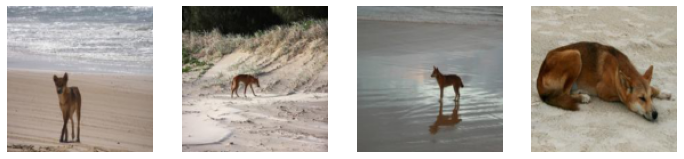

In [39]:
show_batch(data, 4)

# Training

In [40]:
lr = .001
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback,accuracy),
    partial(ParamScheduler, 'lr', sched_lr),
    partial(ParamScheduler, 'mom', sched_mom),
        partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
#     MixUp,
       partial(CudaCallback, device)]

loss_func=LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [41]:
arch = partial(xresnet18, c_out =n_classes)()
clear_memory()
learn = Learner(arch, data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [42]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.205646,0.202563,2.085978,0.270470,00:17


In [202]:
freeze_to(learn,-2)

In [203]:
learn.fit(4)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.048877,0.292088,2.059904,0.281723,00:05
1,2.033075,0.300183,2.035260,0.303842,00:05
2,2.016831,0.305580,2.027118,0.311215,00:05
3,2.003603,0.316565,2.021991,0.300737,00:05


In [204]:
freeze_to(learn)
total_layer_state(learn)

'Frozen: 68, Not: 0, Total: 68'

In [205]:
learn.fit(1) # should break because fully frozen

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [193]:
unfreeze_to(learn)

In [188]:
total_layer_state(learn)

'Frozen: 2, Not: 66, Total: 68'